In [1]:
# Import necessary libraries for data handling, model utilization, and visualization
import numpy as np
import pandas as pd
import yfinance as yf  # For collecting financial data
import matplotlib.pyplot as plt
from typing import List, Dict, Optional, Tuple
from scipy.optimize import minimize 
# Import the custom Model class
from Model import Model

# Set the random seed for reproducibility across numpy and tensorflow
np.random.seed(123)

# Optional: Configure plotting style for a consistent look
plt.style.use('seaborn-darkgrid')

# Define the tickers and date range with consideration of trading days
TICKERS = ['VTI','AGG','DBC','VIXY']  # Example tickers for the portfolio
START_DATE = '2010-01-01'
END_DATE = '2020-12-31'

# Approximate number of trading days per year (useful for annualizing returns)
TRADING_DAYS_PER_YEAR = 252

# Confirm setup
print("Setup complete: libraries imported, random seed set, and tickers defined.")


Setup complete: libraries imported, random seed set, and tickers defined.


C:\Users\wiztu\AppData\Local\Temp\ipykernel_33608\3914941183.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [2]:
# Data Collection Step
# Objective: Fetch historical adjusted close prices for defined tickers and date range

# Download data using yfinance for the specified tickers and date range
def get_data(tickers, start_date, end_date):
    """
    Retrieves historical adjusted close prices for the given tickers and date range.
    
    Parameters:
    - tickers: List of stock ticker symbols
    - start_date: Start date for historical data
    - end_date: End date for historical data
    
    Returns:
    - DataFrame of adjusted close prices, with each column representing a ticker
    """
    # Fetch data from yfinance
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    
    # Drop rows with missing values, if any, to ensure data continuity
    data.dropna(inplace=True)
    
    return data

# Fetch the data and display a quick preview
data = get_data(TICKERS, START_DATE, END_DATE)
print("Data fetched successfully. Sample data:")
print(data.head())

# Confirm data spans the expected range and has the expected number of columns
print(f"Data covers {len(data)} trading days with {len(data.columns)} assets.")


[*********************100%%**********************]  4 of 4 completed

Data fetched successfully. Sample data:
Ticker            AGG        DBC      VIXY        VTI
Date                                                 
2011-01-04  73.396126  25.130905  158460.0  51.113720
2011-01-05  73.041870  25.397865  155100.0  51.394760
2011-01-06  73.055786  25.057262  155760.0  51.277668
2011-01-07  73.291916  24.965206  156080.0  51.160553
2011-01-10  73.486397  25.259781  155760.0  51.199600
Data covers 2515 trading days with 4 assets.


In [3]:
# Data Preprocessing Step
# Objective: Prepare data by calculating daily returns and normalizing for model input

def preprocess_data(data):
    """
    Prepares data for the LSTM model by calculating returns and normalizing prices.

    Parameters:
    - data: DataFrame of historical adjusted close prices for assets

    Returns:
    - normalized_data: DataFrame with prices normalized to start at 1 for each asset
    - returns: DataFrame with daily returns for each asset
    """
    # Calculate daily returns as percentage changes
    returns = data.pct_change().dropna()
    
    # Normalize prices so each series starts at 1
    normalized_data = data / data.iloc[0]
    
    return normalized_data, returns

# Run preprocessing and display sample data
normalized_data, returns = preprocess_data(data)
print("Data preprocessing complete. Sample normalized data:")
print(normalized_data.head())
print("\nSample daily returns:")
print(returns.head())


Data preprocessing complete. Sample normalized data:
Ticker           AGG       DBC      VIXY       VTI
Date                                              
2011-01-04  1.000000  1.000000  1.000000  1.000000
2011-01-05  0.995173  1.010623  0.978796  1.005498
2011-01-06  0.995363  0.997070  0.982961  1.003208
2011-01-07  0.998580  0.993407  0.984980  1.000916
2011-01-10  1.001230  1.005128  0.982961  1.001680

Sample daily returns:
Ticker           AGG       DBC      VIXY       VTI
Date                                              
2011-01-05 -0.004827  0.010623 -0.021204  0.005498
2011-01-06  0.000191 -0.013411  0.004255 -0.002278
2011-01-07  0.003232 -0.003674  0.002054 -0.002284
2011-01-10  0.002654  0.011799 -0.002050  0.000763
2011-01-11 -0.001984  0.011297 -0.027607  0.003965


In [4]:
class Portfolio:
    def __init__(self, initial_cash: float, assets: pd.DataFrame):
        """
        Initializes the Portfolio object.

        Parameters:
        - initial_cash: The starting value of the portfolio in cash.
        - assets: DataFrame of asset prices (historical data).
        """
        self.initial_cash = initial_cash
        self.current_value = initial_cash
        self.assets = assets  # Historical price data for the assets
        self.weights = np.zeros(len(assets.columns))  # Initialize weights as zero
        self.portfolio_history = []  # To track portfolio value over time
        self.rebalancing_dates = []  # To store rebalancing dates

    def rebalance(self, new_weights: np.array):
        """
        Rebalances the portfolio according to new weights.

        Parameters:
        - new_weights: Numpy array of asset allocations.
        """
        if len(new_weights) != len(self.assets.columns):
            raise ValueError("Number of weights must match the number of assets.")
        self.weights = new_weights

    def calculate_initial_shares(self, initial_cash):
        """
        Calculates the number of shares for each asset at the start of the testing period based on
        initial cash and allocation weights.

        Parameters:
        - initial_cash: The starting cash value of the portfolio.

        Returns:
        - shares: Dictionary with tickers as keys and the initial number of shares as values.
        """
        # Calculate the dollar amount allocated to each asset
        dollar_allocation = initial_cash * self.weights

        # Get the prices at the start of the testing period
        initial_prices = self.assets.iloc[0]

        # Calculate the number of shares for each asset
        shares = (dollar_allocation // initial_prices).astype(int)  # Floor division to get whole shares

        # Return as a dictionary for easy readability
        return dict(zip(self.assets.columns, shares))
    
    def calculate_daily_returns(self):
        """
        Applies the current weights to asset returns and updates portfolio value over time.
        """
        # Calculate daily returns for each asset
        daily_returns = self.assets.pct_change().dropna()
        
        # Calculate portfolio returns by applying weights
        portfolio_returns = np.dot(daily_returns, self.weights)

        # Track the portfolio's value over time by compounding the returns
        for daily_ret in portfolio_returns:
            self.current_value *= (1 + daily_ret)
            self.portfolio_history.append(self.current_value)

    def track_portfolio_performance(self):
        """
        Tracks and prints the portfolio performance over time.
        """
        for date, value in zip(self.assets.index[1:], self.portfolio_history):
            print(f"Date: {date}, Portfolio Value: {value}")

    def get_portfolio_value(self):
        """
        Returns the current value of the portfolio.
        """
        return self.current_value
    
    def plot_portfolio_value(self):
        """
        Plots the portfolio value over time.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(self.assets.index[1:], self.portfolio_history, label="Portfolio Value")
        plt.title("Portfolio Value Over Time")
        plt.xlabel("Date")
        plt.ylabel("Portfolio Value")
        plt.legend()
        plt.show()

In [5]:
def train_and_rebalance_portfolio(portfolio: Portfolio, frequency: int, model: Model):
    """
    Trains the LSTM model and rebalances the portfolio at the end of each specified interval.

    Parameters:
    - portfolio: An instance of the Portfolio class.
    - frequency: The frequency of rebalancing in days.
    - model: An instance of the Model class for training.
    """
    num_days = len(portfolio.assets)
    start_index = 0

    while start_index < num_days:
        # Determine the end index for the current training period
        end_index = min(start_index + frequency, num_days)

        # Slice the data for the training period
        train_data = portfolio.assets.iloc[start_index:end_index]

        # Preprocess the training data
        normalized_data, _ = preprocess_data(train_data)

        # Get allocations from the model
        allocations = model.get_allocations(normalized_data)

        # Rebalance the portfolio with the optimized weights
        portfolio.rebalance(allocations)

        # Store the rebalancing date
        portfolio.rebalancing_dates.append(train_data.index[-1])

        # Move to the next period
        start_index += frequency
    return allocations

In [6]:
def calculate_metrics(portfolio_values):
    """
    Calculates performance metrics for the portfolio.

    Parameters:
    - portfolio_values: List of daily portfolio values over the testing period.

    Returns:
    - metrics: Dictionary containing Sharpe Ratio, Sortino Ratio, and Max Drawdown.
    """
    # Convert portfolio values to daily returns
    portfolio_returns = np.diff(portfolio_values) / portfolio_values[:-1]
    
    # Calculate Sharpe Ratio
    mean_return = np.mean(portfolio_returns)
    std_dev = np.std(portfolio_returns)
    sharpe_ratio = mean_return / std_dev * np.sqrt(TRADING_DAYS_PER_YEAR)
    
    # Calculate Sortino Ratio
    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_std_dev = np.std(downside_returns)
    sortino_ratio = mean_return / downside_std_dev * np.sqrt(TRADING_DAYS_PER_YEAR)
    
    # Calculate Maximum Drawdown
    cumulative_returns = np.maximum.accumulate(portfolio_values) - portfolio_values
    max_drawdown = np.max(cumulative_returns / np.maximum.accumulate(portfolio_values))
    
    return {
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown
    }


In [7]:
def equal_weighted_strategy(returns):
    """
    Creates an equal-weighted portfolio.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - equal_weights: Numpy array of equal weights for each asset.
    """
    num_assets = returns.shape[1]
    equal_weights = np.ones(num_assets) / num_assets
    return equal_weights

def mean_variance_optimized_strategy(returns):
    """
    Creates a mean-variance optimized portfolio by maximizing the Sharpe Ratio.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - optimized_weights: Numpy array of optimized weights for each asset.
    """
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    
    def neg_sharpe(weights):
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -portfolio_return / portfolio_std

    # Constraints: Weights must sum to 1, and each weight must be between 0 and 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(returns.shape[1]))

    result = minimize(neg_sharpe, np.ones(returns.shape[1]) / returns.shape[1], bounds=bounds, constraints=constraints)
    optimized_weights = result.x
    
    return optimized_weights

[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed
c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1479
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1267
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1096
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0947
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0803
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0647
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0452
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0173
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: -0.0293
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: -0.1187
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: -0.2920
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: -0.4349
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: -0.3970
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: -0.3637
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: -0.3494
Epoch 16/100
1

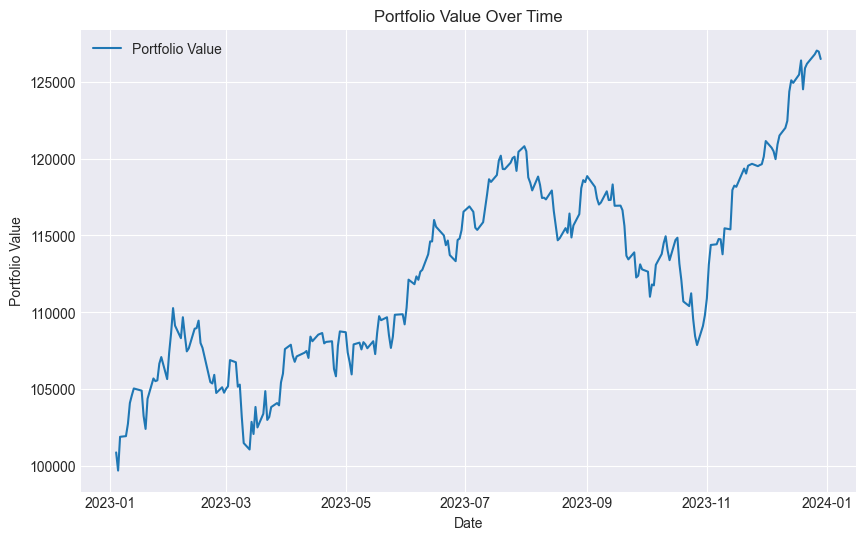

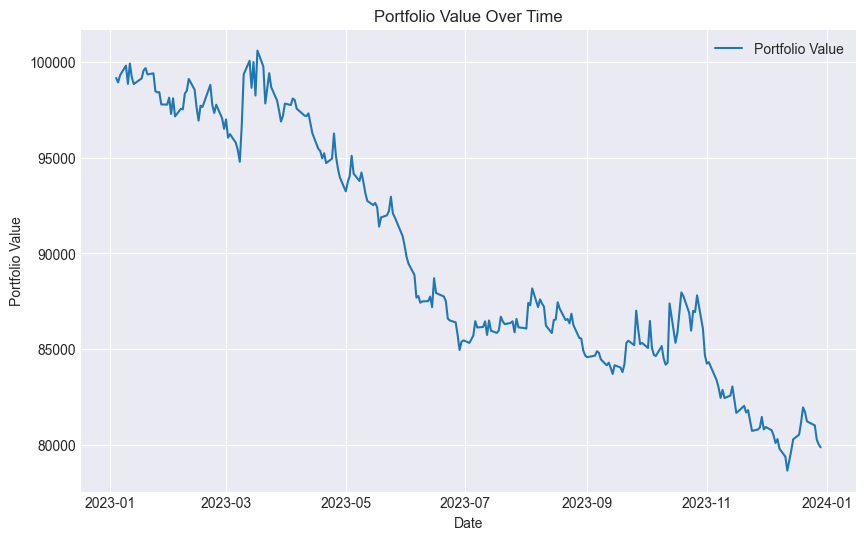

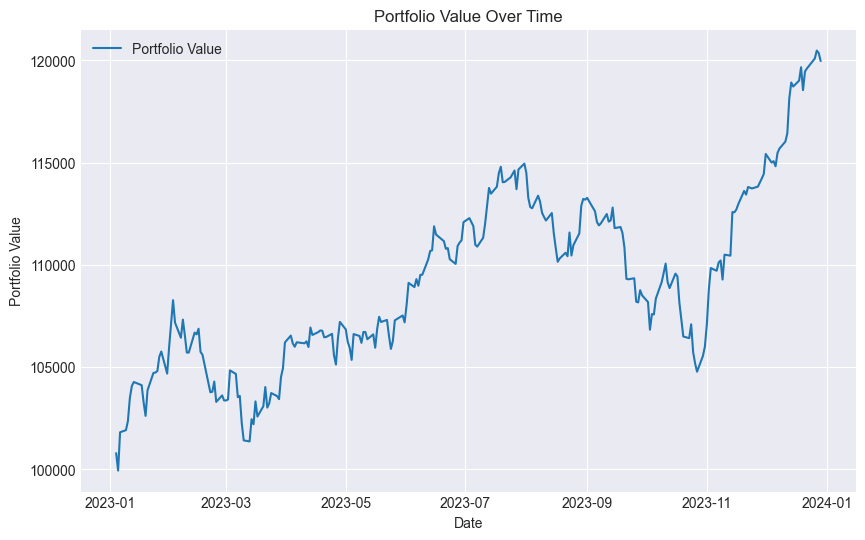

LSTM Portfolio Metrics:
Weights:[4.1505479e-04 1.5268497e-05 4.5530414e-04 9.9911433e-01], Shares:{'AGG': 41, 'DBC': 1, 'VIXY': 45, 'VTI': 99911}
{'Sharpe Ratio': 1.7716951644607661, 'Sortino Ratio': 2.939377588411626, 'Max Drawdown': 0.10705305101521678}

Equal-Weighted Portfolio Metrics:
Weights:[0.25 0.25 0.25 0.25], Shares:{'AGG': 25000, 'DBC': 25000, 'VIXY': 25000, 'VTI': 25000}
{'Sharpe Ratio': -1.6968182177920448, 'Sortino Ratio': -3.1654847057226485, 'Max Drawdown': 0.2180420576062195}

Mean-Variance Optimized Portfolio Metrics:
Weights:[2.98705005e-01 1.73472348e-18 5.42101086e-18 7.01294995e-01], Shares:{'AGG': 29870, 'DBC': 0, 'VIXY': 0, 'VTI': 70129}
{'Sharpe Ratio': 1.8073291052057772, 'Sortino Ratio': 3.0498640842387, 'Max Drawdown': 0.08852875165325765}


In [8]:
# Step 1: Data Preparation for Training and Testing
train_data = get_data(TICKERS, '2020-01-01', '2023-01-01')
normalized_train_data, _ = preprocess_data(train_data)

testing_data = get_data(TICKERS, '2023-01-01', '2024-01-01')
normalized_testing_data, testing_returns = preprocess_data(testing_data)

# Step 2: Train and Rebalance Portfolio in Training Phase (rebalancing every two years)
training_portfolio = Portfolio(100000, normalized_train_data)
model = Model()

# Rebalance every 2 years (252 trading days * 2)
final_allocations = train_and_rebalance_portfolio(training_portfolio, frequency=30, model=model)

# Step 3: Initialize Testing Portfolio with Final LSTM Weights
testing_portfolio = Portfolio(100000, normalized_testing_data)
testing_portfolio.rebalance(final_allocations)
LSTM_shares = testing_portfolio.calculate_initial_shares(100000)  # Calculate initial shares based on final allocations
testing_portfolio.calculate_daily_returns()     # Track performance in testing period
testing_portfolio.plot_portfolio_value()        # Visualize portfolio value over time
# Step 4: Calculate Performance Metrics for LSTM Portfolio
metrics = calculate_metrics(testing_portfolio.portfolio_history)

# Step 5: Baseline Strategies Setup and Evaluation
# Equal-Weighted and Mean-Variance Optimized Portfolios
equal_weights = equal_weighted_strategy(testing_returns)
mv_optimized_weights = mean_variance_optimized_strategy(testing_returns)

equal_weight_portfolio = Portfolio(100000, normalized_testing_data)
mv_optimized_portfolio = Portfolio(100000, normalized_testing_data)

equal_weight_portfolio.rebalance(equal_weights)
mv_optimized_portfolio.rebalance(mv_optimized_weights)

equal_weight_portfolio.calculate_daily_returns()
mv_optimized_portfolio.calculate_daily_returns()
ew_shares = equal_weight_portfolio.calculate_initial_shares(100000)
mv_shares = mv_optimized_portfolio.calculate_initial_shares(100000)
equal_weight_portfolio.plot_portfolio_value()
mv_optimized_portfolio.plot_portfolio_value()
# Step 6: Calculate Performance Metrics for Baseline Portfolios
equal_weight_metrics = calculate_metrics(equal_weight_portfolio.portfolio_history)
mv_optimized_metrics = calculate_metrics(mv_optimized_portfolio.portfolio_history)

print("LSTM Portfolio Metrics:")
print(f"Weights:{final_allocations}, Shares:{LSTM_shares}")
print(metrics)
print("\nEqual-Weighted Portfolio Metrics:")
print(f"Weights:{equal_weights}, Shares:{ew_shares}")
print(equal_weight_metrics)

print("\nMean-Variance Optimized Portfolio Metrics:")
print(f"Weights:{mv_optimized_weights}, Shares:{mv_shares}")
print(mv_optimized_metrics)
